In [2]:
import torch
import numpy as np
import scipy
import os

np.set_printoptions(precision = 3, suppress = True, linewidth = 10000, threshold = 100000)

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# If the fonts in the plots are incorrectly rendered comment out the next two lines
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
matplotlib.rcParams['lines.linewidth'] = 2.0

import urllib.request
from urllib.error import HTTPError

CHECKPOINT_PATH = "./saved_models/GDL"

/tmp/ipykernel_1563054/875589264.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Files to download
pretrained_files = [
    "steerable_c4_pretrained.ckpt",
    "steerable_so2_pretrained.ckpt",
    "steerable_c4_accuracies.npy",
    "steerable_so2_accuracies.npy",
]

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"

# For each file, check whether it already exists. If not, try downloading it
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(f"Something went wrong. Please contact the author with the full output including the following error:\n", e)

Something went wrong. Please contact the author with the full output including the following error:
 HTTP Error 404: Not Found
Something went wrong. Please contact the author with the full output including the following error:
 HTTP Error 404: Not Found
Something went wrong. Please contact the author with the full output including the following error:
 HTTP Error 404: Not Found
Something went wrong. Please contact the author with the full output including the following error:
 HTTP Error 404: Not Found


## 1. Representation Theory and Harmonic Analysis of Compact Groups

### 1.0 General group class

In [4]:
try:
    from escnn.group import *
except ModuleNotFoundError: # Installing escnn if not installed
    !pip3 install escnn
    from escnn.group import *

In [5]:
G = cyclic_group(N = 8)

# We can verify that the order of the group is 8:
G.order()

8

In [6]:
G.identity

0[2pi/8]

In [7]:
G.sample()

1[2pi/8]

In [8]:
a = G.sample()
b = G.sample()
print(a)
print(b)
print(a @ b)
print(~a)

0[2pi/8]
4[2pi/8]
4[2pi/8]
0[2pi/8]


### 1.1 Group representation

In [9]:
# Trivial representation: g -> 1
rho = G.trivial_representation

In [10]:
rho

C8|[irrep_0]:1

In [11]:
g1 = G.sample()
g2 = G.sample()
print(rho(g1) @ rho(g2))
print(rho(g1 @ g2))

[[1.]]
[[1.]]


In [12]:
rho.size

1

In [13]:
# rotation group SO2: all rotation in 2D, characterized by theta [0, 2pi)
G = so2_group()
rho = G.standard_representation()

g1 = G.sample()
g2 = G.sample()
print(f'g1={g1}, g2={g2}, g1*g2 = {g1 @ g2}')
print()
print('rho(g1) @ rho(g2)')
print(rho(g1) @ rho(g2))
print()
print('rho(g1 * g2)')
print(rho(g1 @ g2))

g1=0.5422461677335817, g2=2.3228271564087133, g1*g2 = 2.865073324142295

rho(g1) @ rho(g2)
[[-0.962 -0.273]
 [ 0.273 -0.962]]

rho(g1 * g2)
[[-0.962 -0.273]
 [ 0.273 -0.962]]


In [14]:
# Direct sum:
rho_sum = rho + rho

g = G.sample()
print(rho(g))
print()
print(rho_sum(g))

[[ 0.998  0.064]
 [-0.064  0.998]]

[[ 0.998  0.064  0.     0.   ]
 [-0.064  0.998  0.     0.   ]
 [ 0.     0.     0.998  0.064]
 [ 0.     0.    -0.064  0.998]]


In [15]:
rho.size, rho_sum.size

(2, 4)

In [16]:
rho_sum = rho + rho + rho + rho

# or, more simple:
rho_sum = directsum([rho, rho, rho, rho])
rho_sum.size

8

In [17]:
# Regular representation
G = cyclic_group(8)

rho = G.regular_representation

In [18]:
# Note that the size of the representation is equal to the group's order |G|
rho.size

8

In [19]:
rho(G.identity)

array([[ 1.,  0., -0.,  0., -0., -0.,  0., -0.],
       [ 0.,  1.,  0., -0.,  0., -0., -0., -0.],
       [-0.,  0.,  1.,  0., -0.,  0.,  0.,  0.],
       [ 0., -0.,  0.,  1.,  0., -0.,  0., -0.],
       [-0.,  0., -0.,  0.,  1.,  0., -0., -0.],
       [-0., -0.,  0., -0.,  0.,  1., -0.,  0.],
       [ 0., -0.,  0.,  0., -0., -0.,  1., -0.],
       [-0., -0.,  0., -0., -0.,  0., -0.,  1.]])

In [20]:
rho(G.element(1))

array([[ 0.,  0.,  0., -0., -0.,  0., -0.,  1.],
       [ 1.,  0., -0., -0., -0., -0.,  0., -0.],
       [ 0.,  1.,  0., -0.,  0., -0., -0., -0.],
       [-0.,  0.,  1.,  0., -0.,  0.,  0.,  0.],
       [ 0., -0.,  0.,  1.,  0., -0.,  0., -0.],
       [-0.,  0., -0.,  0.,  1.,  0.,  0., -0.],
       [-0., -0.,  0., -0.,  0.,  1.,  0.,  0.],
       [-0.,  0.,  0., -0.,  0., -0.,  1.,  0.]])

In [21]:
f = np.zeros(8)
f[0] = 1

f

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
rho(G.identity) @ f

array([ 1.,  0., -0.,  0., -0., -0.,  0., -0.])

In [23]:
rho(G.element(1)) @ f

array([ 0.,  1.,  0., -0.,  0., -0., -0., -0.])

In [24]:
rho(G.element(6)) @ f

array([ 0.,  0., -0.,  0., -0., -0.,  1., -0.])

In [25]:
# Regular representation from the direct sum
d = G.trivial_representation.size * 2 + G.regular_representation.size * 2
Q = np.random.randn(d, d)

rho = directsum(
    [G.trivial_representation, G.regular_representation, G.regular_representation, G.trivial_representation],
    change_of_basis= Q 
    )

In [26]:
rho.size

18

In [27]:
# Irreducable representations
# 0 is the trivial representation (similar to constant basis func)
rho_0 = G.irrep(0)

print(rho_0 == G.trivial_representation)

print(G.sample())
rho_0(G.sample())

True
6[2pi/8]


array([[1.]])

In [28]:
# 1 is rotation by i * 2pi/8
rho = G.irrep(1)
g = G.sample()

print(g)
print()
print(rho(g))

6[2pi/8]

[[-0.  1.]
 [-1. -0.]]


In [29]:
# Decomposion regular representation into irreps
rho = G.regular_representation
rho.irreps

[(0,), (1,), (2,), (3,), (4,)]

In [30]:
rho.change_of_basis

array([[ 0.354,  0.5  ,  0.   ,  0.5  ,  0.   ,  0.5  ,  0.   ,  0.354],
       [ 0.354,  0.354,  0.354,  0.   ,  0.5  , -0.354,  0.354, -0.354],
       [ 0.354,  0.   ,  0.5  , -0.5  ,  0.   , -0.   , -0.5  ,  0.354],
       [ 0.354, -0.354,  0.354, -0.   , -0.5  ,  0.354,  0.354, -0.354],
       [ 0.354, -0.5  ,  0.   ,  0.5  , -0.   , -0.5  ,  0.   ,  0.354],
       [ 0.354, -0.354, -0.354,  0.   ,  0.5  ,  0.354, -0.354, -0.354],
       [ 0.354, -0.   , -0.5  , -0.5  ,  0.   ,  0.   ,  0.5  ,  0.354],
       [ 0.354,  0.354, -0.354, -0.   , -0.5  , -0.354, -0.354, -0.354]])

In [31]:
# let's access second irrep
rho_id = rho.irreps[1]
rho_1 = G.irrep(*rho_id)

# we verify it is the irrep j = 1 we described before
rho_1(g)

array([[-0.,  1.],
       [-1., -0.]])

In [32]:
# evaluate all the irreps in rho.irreps:
irreps = [
    G.irrep(*irrep)(g) for irrep in rho.irreps
]

# build the direct sum
direct_sum = np.asarray(scipy.sparse.block_diag(irreps, format = 'csc').todense())

print('Regular representation of', g)
print(rho(g))
print()
print('Direct sum of the irreps:')
print(direct_sum)
print()
print('Apply the change of basis on the direct sum of the irreps:')
print(rho.change_of_basis @ direct_sum @ rho.change_of_basis_inv)
print()
print('Are the two representations equal?', np.allclose(rho(g), rho.change_of_basis @ direct_sum @ rho.change_of_basis_inv))

Regular representation of 6[2pi/8]
[[ 0. -0.  1.  0. -0.  0.  0.  0.]
 [ 0.  0. -0.  1.  0. -0.  0. -0.]
 [-0. -0.  0. -0.  1.  0. -0. -0.]
 [ 0. -0. -0.  0. -0.  1.  0. -0.]
 [-0.  0.  0. -0.  0. -0.  1.  0.]
 [-0.  0. -0. -0.  0.  0. -0.  1.]
 [ 1.  0. -0.  0. -0. -0.  0. -0.]
 [-0.  1.  0. -0.  0. -0. -0.  0.]]

Direct sum of the irreps:
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -0.  1.  0.  0.  0.  0.  0.]
 [ 0. -1. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1. -0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]

Apply the change of basis on the direct sum of the irreps:
[[ 0. -0.  1.  0. -0.  0.  0.  0.]
 [ 0.  0. -0.  1.  0. -0.  0. -0.]
 [-0. -0.  0. -0.  1.  0. -0. -0.]
 [ 0. -0. -0.  0. -0.  1.  0. -0.]
 [-0.  0.  0. -0.  0. -0.  1.  0.]
 [-0.  0. -0. -0.  0.  0. -0.  1.]
 [ 1.  0. -0.  0. -0. -0.  0. -0.]
 [-0.  1.  0. -0.  0. -0. -0.  0.]]

Are the two representations equal?

### 1.2 Fourier Transform

### Finite group

In [33]:
# Analyses of dihedral group D8
G = dihedral_group(8)

G.order()

16

In [34]:
# element representing the reflection (-) and no rotation
G.reflection

(-, 0[2pi/8])

In [35]:
# element representing a rotation by pi/2 (i.e 2 * 2 pi/8) and no reflection (+)
G.element((0, 2))

(+, 2[2pi/8])

In [36]:
# reflection followed by a rotation by pi/2
print(G.element((0, 2)) @ G.reflection)

# we can also diractly generate this element as 
print(G.element((1, 2)))

(-, 2[2pi/8])
(-, 2[2pi/8])


In [37]:
# a rotation by pi/2 followed by a reflection is equivalent 
# to a reflection followed by a rotation by 6 * 2pi / 8
G.reflection @ G.element((0, 2))

(-, 6[2pi/8])

In [38]:
G.elements

[(+, 0[2pi/8]),
 (+, 1[2pi/8]),
 (+, 2[2pi/8]),
 (+, 3[2pi/8]),
 (+, 4[2pi/8]),
 (+, 5[2pi/8]),
 (+, 6[2pi/8]),
 (+, 7[2pi/8]),
 (-, 0[2pi/8]),
 (-, 1[2pi/8]),
 (-, 2[2pi/8]),
 (-, 3[2pi/8]),
 (-, 4[2pi/8]),
 (-, 5[2pi/8]),
 (-, 6[2pi/8]),
 (-, 7[2pi/8])]

In [39]:
irreps = G.irreps()
print(f"The dihedral group D8 has {len(irreps)} irreps")

The dihedral group D8 has 7 irreps


In [40]:
# the first one, is the 1-dimensional trivial representation
print(irreps[0] == G.trivial_representation == G.irrep(0, 0))

True


In [41]:
def fourier_transform_D8(f: np.array):
    # the method gets in input a function on the elements of D_8
    # and should return a dictionary matting each irrep's 'id' to the corresponding Fourier Transform
    # the i-th element of 'f' stores the value of the function on the group element 'G.elements[i]'
    
    G = dihedral_group(8)
    assert f.shape == (16, ), f.shape
    
    
    
    ft = {j: 1/G.order()*sum([f[i]*irrep.size**(1/2.)*irrep(g) 
                              for i, g in enumerate(G.elements)]) 
          for j, irrep in enumerate(G.irreps())
         }
    
    
    
    return ft


def inverse_fourier_transform_D8(ft: dict):
    # the method get in input a dictionary mapping irrep's 'id' to the corresponding Forier Transform
    # and should return the function 'f' on the elements of D_8
    # The i-th element of 'f' stores the value of the function on the group element 'G.elements[i]'
    
    G = dihedral_group(8)
    f = np.zeros(16)
    
    for i, g in enumerate(G.elements):
        f[i] = sum([irrep.size**(1/2.)*np.trace(irrep(g).T@ft[j]) for j, irrep in enumerate(G.irreps())])
    
    return f

In [42]:
f = np.random.randn(16)
 
ft = fourier_transform_D8(f)

new_f = inverse_fourier_transform_D8(ft)

assert np.allclose(f, new_f)

### Infinite group

In [43]:
G = o2_group()

In [44]:
# the group has infinite many elements, so the 'order' method just returns -1
G.order()

-1

In [45]:
def inverse_fourier_transform_O2(g: GroupElement, ft: dict):
    # the method gets in input a dictionary mapping each irrep's 'id' to the corresponding Fourier Transform
    # and a group element 'g'
    # The method should return the value of the function evaluated on 'g'
    
    G = o2_group()
    f = 0
    
    for j, w_rho in ft.items():
        f += G.irrep(*j).size**(1/2.)*np.trace(G.irrep(*j)(g).T @ w_rho)
    
    return f

In [46]:
irreps = [G.irrep(0, 0)] + [G.irrep(1, j) for j in range(3)]

ft = {
    rho.id: np.random.randn(rho.size, rho.size)
    for rho in irreps
}

In [47]:
G.sample()

(+, 5.313427899175599)

In [48]:
N = 100
thetas = [i*2*np.pi/N for i in range(N)]
grid_rot = [G.element((0, theta)) for theta in thetas]
grid_refl = [G.element((1, theta)) for theta in thetas]

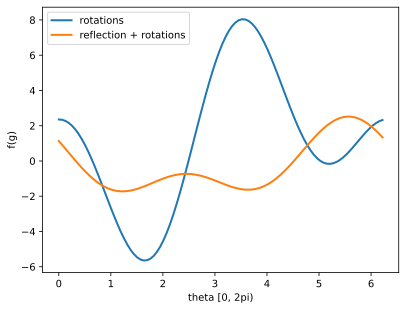

In [49]:
f_rot = [
    inverse_fourier_transform_O2(g, ft) for g in grid_rot
        ]
f_refl = [
    inverse_fourier_transform_O2(g, ft) for g in grid_refl
        ]


plt.plot(thetas, f_rot, label = 'rotations')
plt.plot(thetas, f_refl, label = 'reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('f(g)')
plt.legend()
plt.show()

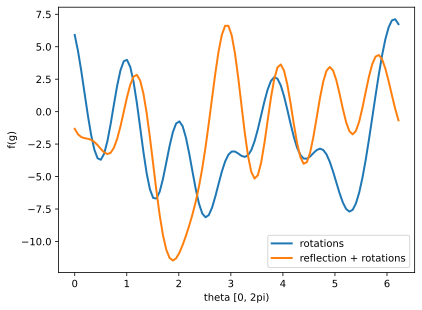

In [50]:
# more irreps
irreps = [G.irrep(0, 0)] + [G.irrep(1, j) for j in range(8)]

ft = {
    rho.id: np.random.randn(rho.size, rho.size)
    for rho in irreps
}


f_rot = [
    inverse_fourier_transform_O2(g, ft) for g in grid_rot
        ]
f_refl = [
    inverse_fourier_transform_O2(g, ft) for g in grid_refl
        ]


plt.plot(thetas, f_rot, label = 'rotations')
plt.plot(thetas, f_refl, label = 'reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('f(g)')
plt.legend()
plt.show()

### Fourier transform of shifted function

Transforming the function with g = (+, 3.378092767037106)


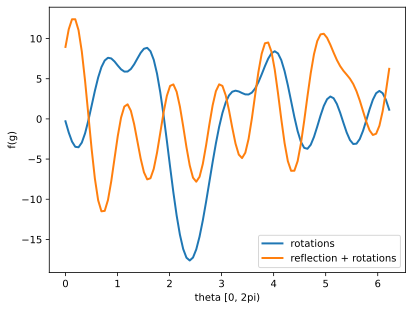

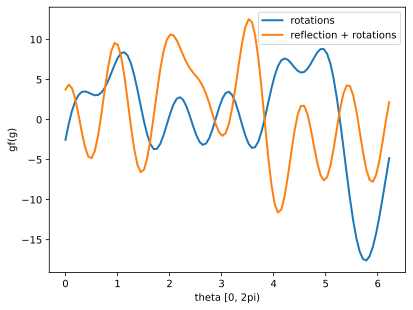

In [51]:
irreps = [G.irrep(0, 0)] + [G.irrep(1, j) for j in range(8)]

# first, we generate a random function, as earlier
ft = {
    rho.id: np.random.randn(rho.size, rho.size)
    for rho in irreps
}

# second, we sample a random group element 'g'
g = G.sample()
print(f'Transforming the function with g = {g}')

# finally, we transform the Fourier coefficients as in the equation above:
gft = {
    rho.id: rho(g) @ ft[rho.id]
    for rho in irreps
}

# Let's now visualize two functions:

f_rot = [
    inverse_fourier_transform_O2(g, ft) for g in grid_rot
        ]
f_refl = [
    inverse_fourier_transform_O2(g, ft) for g in grid_refl
        ]

gf_rot = [
    inverse_fourier_transform_O2(g, gft) for g in grid_rot
        ]
gf_refl = [
    inverse_fourier_transform_O2(g, gft) for g in grid_refl
        ]


plt.plot(thetas, f_rot, label = 'rotations')
plt.plot(thetas, f_refl, label = 'reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('f(g)')
plt.legend()
plt.show()

plt.plot(thetas, gf_rot, label = 'rotations')
plt.plot(thetas, gf_refl, label = 'reflection + rotations')
plt.xlabel('theta [0, 2pi)')
plt.ylabel('gf(g)')
plt.legend()
plt.show()

### From Fourier transform to regular representation

In [52]:
G = dihedral_group(8)

rho_irreps = []

for rho_j in G.irreps():
    d_j = rho_j.size
    # repeat each irrep a number of time equal to its size
    rho_irreps += [rho_j]*d_j
    
rho = directsum(rho_irreps)

print('The representation have the size:')
print(rho.size, G.regular_representation.size)

print('And contain the same irreps:')
print(rho.irreps)
print(G.regular_representation.irreps)

# Fourier transform matrix:
Q = G.regular_representation.change_of_basis
# Inverse Fourier transform matrix:
Qinv = G.regular_representation.change_of_basis_inv

# Let's check that the two representations are ineed equivalent
g= G.sample()

rho_g = rho(g)
reg_g = G.regular_representation(g)
print()
print("Are the two representations equivalent?", np.allclose(Q @ rho_g @ Qinv, reg_g))

The representation have the size:
16 16
And contain the same irreps:
[(0, 0), (1, 0), (1, 1), (1, 1), (1, 2), (1, 2), (1, 3), (1, 3), (1, 4), (0, 4)]
[(0, 0), (1, 0), (1, 1), (1, 1), (1, 2), (1, 2), (1, 3), (1, 3), (1, 4), (0, 4)]

Are the two representations equivalent? True


In [53]:
# Generating finite regular representation of infinite group
G = o2_group()

rho = G.bl_regular_representation(7)

rho.irreps

[(0, 0),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 2),
 (1, 2),
 (1, 3),
 (1, 3),
 (1, 4),
 (1, 4),
 (1, 5),
 (1, 5),
 (1, 6),
 (1, 6),
 (1, 7),
 (1, 7)]

In [54]:
G = so2_group()

rho = G.bl_regular_representation(7)

# observe that each irrep is now repeated only once, even if some are 2-dimensional
rho.irreps, [G.irrep(*el).size for el in rho.irreps]

([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,)], [1, 2, 2, 2, 2, 2, 2, 2])

### 2. From Group CNNs to Steerable CNNs

### 2.2 Defining a Steerable CNN

In [55]:
from escnn import group
from escnn import gspaces
from escnn import nn

In [56]:
r2_act = gspaces.rot2dOnR2(N = 4)
r2_act

C4_on_R2[(None, 4)]

In [57]:
# we can access the group G as
G = r2_act.fibergroup
G

C4

In [58]:
feat_type = nn.FieldType(r2_act, [G.regular_representation])

feat_type

[C4_on_R2[(None, 4)]: {regular (x1)}(4)]

In [59]:
G.regular_representation(G.sample())

array([[ 0., -0., -0.,  1.],
       [ 1.,  0., -0., -0.],
       [ 0.,  1.,  0., -0.],
       [-0.,  0.,  1.,  0.]])

In [60]:
# Technically, one can also construct the direct-sum representation G.regular_representation 
# + G.regular_representation + G.regular_representation  as done before. Passing a list containing 3 copies of G.regular_representation
# allows for more efficient implementation of certain operations internally
feat_type = nn.FieldType(r2_act, [G.regular_representation]*3)
feat_type

[C4_on_R2[(None, 4)]: {regular (x3)}(12)]

In [61]:
# Color (gray scale) is represented by trivial representation
feat_type_in = nn.FieldType(r2_act, [G.trivial_representation])
feat_type_in

[C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)]

In [62]:
feat_type_out = nn.FieldType(r2_act, [G.regular_representation]*3)

In [63]:
feat_type_in = nn.FieldType(r2_act, [G.trivial_representation])
feat_type_out = nn.FieldType(r2_act, [G.regular_representation]*3)

In [64]:
# Defining the convolutional filter that preserves equvariance
conv = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)

In [65]:
# Defining random images
x = torch.randn(4, 1, 32, 32)
# FieldType is a callable object; its call method can be used to wrap 
# PyTorch tensors into GeometericTensors
x = feat_type_in(x)

assert isinstance(x.tensor, torch.Tensor)
assert isinstance(x, nn.GeometricTensor)

In [66]:
# Forward operation same as before
y = conv(x)

In [67]:
assert y.type == feat_type_out

In [68]:
# Let's check that the output type transforms accordingly to the input type
for g in G.elements:
    # transfrom the input with the current group element according to the input type
    x_transformed = x.transform(g)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = conv(x_transformed)
    
    # the result should be equivariant to rotationg the output produced in the
    # previous block according to the output type
    y_transformed_from_x = y.transform(g)
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol = 1e-5), g

In [69]:
# Can do ReLU and still preserve equvariance
relu = nn.ReLU(feat_type_out)

z = relu(y)

In [70]:
# once again verify the equivariance
for g in G.elements:
    y_transformed = y.transform(g)
    
    z_from_y_transformed = relu(y_transformed)
    
    z_transformed_from_y = z.transform(g)
    
    assert torch.allclose(z_from_y_transformed.tensor, z_transformed_from_y.tensor, atol = 1e-5), g

In [71]:
# Deep model should preserve dimensions
layer1 = nn.R2Conv(feat_type_in, feat_type_out, kernel_size=3)
later2 = nn.ReLU(feat_type_in) # the input type of the ReLU should be the output type of the convolution

x = feat_type_in(torch.randn(3, 1, 7, 7))

try:
    y = later2(layer1(x))
except AssertionError as e:
    print(e)

Error! the type of the input does not match the input type of this module


In [72]:
# Sequential module 
feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid, inplace = True),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid, inplace = True),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()

In [73]:
# Check the equivariance
# Let's check that the output type transforms accordingly to the input type
x = torch.randn(1, 1, 17, 17)
x = feat_type_in(x)

y = model(x)

# for each group element
for g in G.elements:
    # transfrom the input with the current group element according to the input type
    x_transformed = x.transform(g)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = model(x_transformed)
    
    # the result should be equivariant to rotationg the output produced in the
    # previous block according to the output type
    y_transformed_from_x = y.transform(g)
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol = 1e-5), g

In [74]:
# average pooling with the findow size 11
avgpool = nn.PointwiseAvgPool(feat_type_out, 11)

y = avgpool(model(x))

y.shape

torch.Size([1, 8, 1, 1])

In [75]:
for g in G.elements:
    print(f'rotation by {g}:', y.transform(g).tensor[0, ...].detach().numpy().squeeze())

rotation by 0[2pi/4]: [0.143 0.108 0.136 0.167 0.277 0.266 0.2   0.255]
rotation by 1[2pi/4]: [0.167 0.143 0.108 0.136 0.255 0.277 0.266 0.2  ]
rotation by 2[2pi/4]: [0.136 0.167 0.143 0.108 0.2   0.255 0.277 0.266]
rotation by 3[2pi/4]: [0.108 0.136 0.167 0.143 0.266 0.2   0.255 0.277]


In [76]:
invariant_map = nn.GroupPooling(feat_type_out)

y = invariant_map(avgpool(model(x)))

for g in G.elements:
    print(f'rotation by {g}:', y.transform(g).tensor[0, ...].detach().numpy().squeeze())

rotation by 0[2pi/4]: [0.167 0.277]
rotation by 1[2pi/4]: [0.167 0.277]
rotation by 2[2pi/4]: [0.167 0.277]
rotation by 3[2pi/4]: [0.167 0.277]


In [77]:
# Check invariance under translation in this case

# for each group element
for g in G.elements:
    # transfrom the input with the current group element according to the input type
    x_transformed = x.transform(g)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = invariant_map(avgpool(model(x_transformed)))
    
    # the result should be equivariant to rotationg the output produced in the
    # previous block according to the output type
    y_transformed_from_x = y
    
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol = 1e-5), g

### Infinite group G

In [78]:
# use N = -1 to indicate all retations
r2_act = gspaces.rot2dOnR2(N = -1)
r2_act

SO(2)_on_R2[(None, -1)]

In [79]:
G = r2_act.fibergroup
G

SO(2)

In [80]:
# For simplicity we take a single-channel gray-scale image in input 
# and we output a single-channel gray-scale image 
# i.e. we use scalar in input and output
feat_type_in = nn.FieldType(r2_act, [G.trivial_representation])
feat_type_out = nn.FieldType(r2_act, [G.trivial_representation])

In [81]:
# sample the nonlinearity
nonlinearity = nn.FourierELU(r2_act, 16, irreps = G.bl_irreps(2), N = 12)
# we do not need to pre-define the feature type: FourierELU 
# will create it internally and we can just access it as
feat_type_hid = nonlinearity.in_type

# note also that its input and output types are the same
assert nonlinearity.in_type == nonlinearity.out_type

In [82]:
# SO2 equivariant model
equivariant_so2_model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=7),
    nn.IIDBatchNorm2d(feat_type_hid),
    nonlinearity,
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=7),
    nonlinearity,
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=7),
).eval()

In [83]:
# Check equivariance
x = torch.randn(1, 1, 23, 23)
x = feat_type_in(x)

y = equivariant_so2_model(x)

# check equivariance to N = 16 rotations
N = 16

try:
    for i in range(N):
        g = G.element(i*2*np.pi/N)
        x_transformed = x.transform(g)
        
        y_from_x_transformed = equivariant_so2_model(x_transformed)
        
        y_transformed_from_x = y.transform(g)
        
        assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol = 1e-3), g
        
except:
    print('Error! The model is not equivariant!')

Error! The model is not equivariant!


In [84]:
# conventional model
conventional_model = torch.nn.Sequential(
    torch.nn.Conv2d(feat_type_in.size, feat_type_hid.size, kernel_size = 7),
    torch.nn.BatchNorm2d(feat_type_hid.size),
    torch.nn.ELU(),
    torch.nn.Conv2d(feat_type_hid.size, feat_type_hid.size, kernel_size = 7),
    torch.nn.BatchNorm2d(feat_type_hid.size),
    torch.nn.ELU(),
    torch.nn.Conv2d(feat_type_hid.size, feat_type_out.size, kernel_size = 7),
).eval()

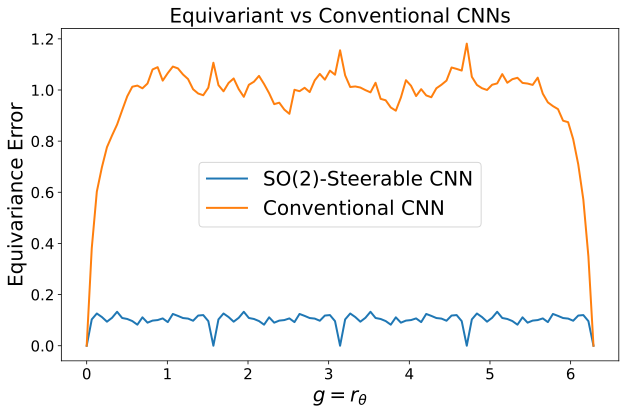

In [85]:
# let's generate a random image of shape W x W
W = 37
x = torch.randn(1, 1, W, W)

# Because a rotation by an angle smaller that 90 degrees moves outsize the image.
# We mask out all pixels outside of the central disk
# We need to do this both for input and the output

def build_mask(W):
    center_mask = np.zeros((2, W, W))
    center_mask[1, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = center_mask[0, :, :].T
    center_mask = center_mask[0, :, :]**2 + center_mask[1, :, :] ** 2 < 0.9*(W // 2) ** 2
    center_mask = torch.tensor(center_mask.reshape(1, 1, W, W), dtype = torch.float)
    
    return center_mask

# create the mask for the input
input_center_mask = build_mask(W)

# mask the input image
x = x * input_center_mask
x = feat_type_in(x)

# compute the output of both model
y_equivariant = equivariant_so2_model(x)
y_conventional = feat_type_out(conventional_model(x.tensor))

# create the mask for the output images
output_center_mask = build_mask(y_equivariant.shape[-1])

# We evaluate the equivariance error on N = 100 rotations
N = 100

error_equivariant = []
error_conventional = []

# for each of the N rotations
for i in range(N + 1):
    g = G.element(i / N * 2*np.pi)
    
    # rotate the input
    x_transformed = x.transform(g)
    x_transformed.tensor *= input_center_mask
    
    # F(g.X) feed the transformed images in both models
    y_from_x_transformed_equivariant = equivariant_so2_model(x_transformed).tensor
    y_from_x_transformed_conventional = conventional_model(x_transformed.tensor)
    
    # g.F(x) transform the output of both models
    y_transformed_from_x_equivariant = y_equivariant.transform(g)
    y_transformed_from_x_conventional = y_conventional.transform(g)
    
    # mask all the outputs
    y_from_x_transformed_equivariant = y_from_x_transformed_equivariant * output_center_mask
    y_from_x_transformed_conventional = y_from_x_transformed_conventional * output_center_mask
    
    y_transformed_from_x_equivariant = y_transformed_from_x_equivariant.tensor * output_center_mask
    y_transformed_from_x_conventional = y_transformed_from_x_conventional.tensor * output_center_mask
    
    # compute the relative error of both models
    rel_error_equivariant = torch.norm(y_from_x_transformed_equivariant - y_transformed_from_x_equivariant).item() / torch.norm(y_equivariant.tensor).item()
    rel_error_conventional = torch.norm(y_from_x_transformed_conventional - y_transformed_from_x_conventional).item() / torch.norm(y_conventional.tensor).item()
    
    error_equivariant.append(rel_error_equivariant)
    error_conventional.append(rel_error_conventional)
    
# plot the error of both models as a function of the rotation angle theta
fig, ax = plt.subplots(figsize = (10, 6))

xs = [i*2*np.pi / N for i in range(N+1)]
plt.plot(xs, error_equivariant, label = 'SO(2)-Steerable CNN')
plt.plot(xs, error_conventional, label = 'Conventional CNN')
plt.title('Equivariant vs Conventional CNNs', fontsize = 20)
plt.xlabel(r'$g = r_\theta$', fontsize = 20)
plt.ylabel('Equivariance Error', fontsize = 20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

### 3. Build and Train Steerable CNNs

### Dataset

In [86]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
# uncompress the zip file
!unzip -n mnist.zip -d mnist

--2024-09-10 21:42:53--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23653151 (23M) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  22.56M  17.0MB/s    in 1.3s    

2024-09-10 21:42:55 (17.0 MB/s) - ‘mnist.zip’ saved [23653151/23653151]

Archive:  mnist.zip
  inflating: mnist/mnist_train.amat  
  inflating: mnist/mnist_test.amat   


In [89]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from tqdm.auto import tqdm

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [90]:
class MnistDataset(Dataset):
    
    def __init__(self, mode, rotated: bool = True):
        assert mode in ['train', 'test']
        
        if mode == 'train':
            file = 'mnist/mnist_train.amat'
        else:
            file = 'mnist/mnist_test.amat'
            
    
        data = np.loadtxt(file)
        
        images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        
        # images are padded to have shape 29 x 29
        # this allows to use odd - size filters with stride 2 
        # when downsampling a feature map in the model
        pad = Pad((0, 0, 1, 1), fill = 0)
        
        # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
        # we upsample an image by a factor of 3, rotate it and finally downsample it again
        resize1 = Resize(87) # to upsample
        resize2 = Resize(29) # to downsample
        
        totensor = ToTensor()
        
        if rotated:
            self.images = torch.empty((images.shape[0], 1, 29, 29))
            for i in tqdm(range(images.shape[0]), leave = False):
                img = images[i]
                img = Image.fromarray(img, mode = 'F')
                r = (np.random.rand() * 360.)
                self.images[i] = totensor(resize2(resize1(pad(img)).rotate(r, Image.BILINEAR))).reshape(1, 29, 29)
                
        else:
            self.images = torch.zeros((images.shape[0], 1, 29, 29))
            self.images[:, :, :28, :28] = torch.tensor(images).reshape(-1, 1, 28, 28)
            
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)
        
    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [91]:
# Set the random seed for reproducibility
np.random.seed(42)

# build the rotated training and test datasetsa
mnist_train = MnistDataset(mode = 'train', rotated=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)


mnist_test = MnistDataset(mode = 'test', rotated=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)


# for testing purpose, we also build a version of the test set with *non*rotated digits
raw_mnist_test = MnistDataset(mode = 'test', rotated=False)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

### SO2 equivariant architecture

In [93]:
class SO2SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes = 10):
        
        super(SO2SteerableCNN, self).__init__()
        
        # the model is equivariant under all planar rotations
        self.r2_act = gspaces.rot2dOnR2(N = -1)
        
        # the group SO(2)
        self.G: SO2 = self.r2_act.fibergroup
            
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = nn.MaskModule(in_type, 29, margin = 1)
        
        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of SO(2) up to frequency 3
        # When taking the ELU non-linearity, we sample the feature fields on N = 16 points
        activation1 = nn.FourierELU(self.r2_act, 8, irreps = G.bl_irreps(3), N = 16, inplace = True)
        out_type = activation1.in_type
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 7, padding = 1, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation1,
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the convolution layer are 16 regular feature fields
        activation2 = nn.FourierELU(self.r2_act, 16, irreps=G.bl_irreps(3), N = 16, inplace=True)
        out_type = activation2.in_type
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation2,
        )
        # to reduce the downsampling artifacts, we a Gaussian smoothing filter
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma = 0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the convolution layer are 32 regular feature fields
        activation3 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N = 16, inplace=True)
        out_type = activation3.in_type
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation3,
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the convolution layer are 64 regular feature fields
        activation4 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N = 16, inplace=True)
        out_type = activation4.in_type
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation4,
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma = 0.66, stride=2)
        ) 
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the convolution layer are 64 regular feature fields
        activation5 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N = 16, inplace=True)
        out_type = activation5.in_type
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation5,
        )        
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the convolution layer are 64 regular feature fields
        activation6 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N = 16, inplace=True)
        out_type = activation6.in_type
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 1, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation6,
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma = 0.66, stride=1, padding = 0)
        
        # number of output invariant channels
        c = 64
        
        # last 1x1 convolutional layer, which maps the regular fields to c = 64 invariant scalar fields
        # this is essential to provide *invariant* features in the final classification layer
        output_invariant_type = nn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = nn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)
        
        # Fully Connected classifier
        self.fully_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(c),
            torch.nn.ELU(inplace = True),
            torch.nn.Linear(c, n_classes),
        )
        
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)
        
        # mask out the corners of the input image
        x = self.mask(x)
        
        # apply each equivariant block 
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # extract the invariant features
        x = self.invariant_map(x)
        
        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [94]:
model = SO2SteerableCNN().to(device)

In [95]:
# test model
def test_model_single_image(model: torch.nn.Module, x: torch.Tensor, N: int = 8):
    np.set_printoptions(linewidth=10000)
    
    x = Image.fromarray(x.cpu().numpy()[0], mode = 'F')
    
    # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
    # we upsample an image by a factor of 3, rotate it and finally downsample it again
    resize1 = Resize(87) # to upsample
    resize2 = Resize(29) # to upsample
    
    totensor = ToTensor()
    
    x = resize1(x)
    
    # evaluate the 'model' on N rotated versions of the input image 'x'
    model.eval()
    
    print()
    print('##############################################################')
    header = 'angle  |  ' + '  '.join(['{:5d}'.format(d) for d in range(10)])
    print(header)
    with torch.no_grad():
        for r in range(N):
            x_transformed = totensor(resize2(x.rotate(r*360./N, Image.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)
            
            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()
            
            angle = r * 360. / N
            print("{:6.1f}: {}".format(angle, y))
    print('##############################################################')
    print()

In [96]:
# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))

# evaluate the model
test_model_single_image(model, x, N = 20)


##############################################################
angle  |      0      1      2      3      4      5      6      7      8      9
   0.0: [-0.135  0.18   0.099  1.412  0.389 -0.402  0.83   0.883  0.474 -0.436]
  18.0: [-0.148  0.195  0.088  1.416  0.391 -0.397  0.826  0.865  0.473 -0.43 ]
  36.0: [-0.146  0.192  0.078  1.417  0.397 -0.387  0.814  0.886  0.471 -0.432]
  54.0: [-0.137  0.184  0.082  1.419  0.406 -0.38   0.815  0.901  0.478 -0.421]
  72.0: [-0.135  0.184  0.089  1.413  0.389 -0.4    0.831  0.892  0.49  -0.417]
  90.0: [-0.135  0.18   0.099  1.412  0.389 -0.402  0.83   0.883  0.474 -0.436]
 108.0: [-0.148  0.195  0.088  1.417  0.391 -0.397  0.826  0.865  0.473 -0.43 ]
 126.0: [-0.146  0.192  0.078  1.417  0.397 -0.388  0.814  0.886  0.471 -0.431]
 144.0: [-0.137  0.185  0.082  1.419  0.406 -0.38   0.815  0.901  0.478 -0.421]
 162.0: [-0.135  0.184  0.089  1.413  0.389 -0.4    0.831  0.892  0.49  -0.417]
 180.0: [-0.135  0.18   0.099  1.412  0.389 -0.402  0.83 

### Training the model

In [97]:
# build the training and test function

def test(model: torch.nn.Module):
    # test over the full rotated test set
    total = 0
    correct = 0
    
    with torch.no_grad():
        model.eval()
        for i, (x, t) in enumerate(test_loader):
            x = x.to(device)
            t = t.to(device)
            
            y = model(x)
            
            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()
            
    return correct/total*100.

def train(model: torch.nn.Module, lr = 1e-4, wd = 1e-4, checkpoint_path: str = None):
    if checkpoint_path is not None:
        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_path)
        
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path), map_location=torch.device('cpu'))
        model.eval()
        return
    
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = wd)
    
    for epoch in tqdm(range(21)):
        model.train()
        for i, (x, t) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x = x.to(device)
            t = t.to(device)
            
            y = model(x)
            
            loss = loss_function(y, t)
            
            loss.backward()
            
            optimizer.step()
            del x, y, t, loss
            
        if epoch % 10 == 0:
            accuracy = test(model)
            print(f"epoch {epoch} | test accuracy: {accuracy}")
        
        if checkpoint_path is not None:
            torch.save(model.state_dict(), checkpoint_path)

In [98]:
# set the seed manually for reproducibiliaty
torch.manual_seed(42)
model = SO2SteerableCNN().to(device)

train(model, checkpoint_path='steerable_so2-pretrained.ckpt')

accuracy = test(model)
print(f"Test accuracy: {accuracy}")

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0 | test accuracy: 86.33
epoch 10 | test accuracy: 93.978
epoch 20 | test accuracy: 95.408
Test accuracy: 95.408


In [101]:
def test_model_rotations(model: torch.nn.Module, 
                         N: int = 24, M: int = 2000, 
                         checkpoint_path: str = None):
    # evaluate the 'model' on N rotated versions of the first M images in the test set
    
    if checkpoint_path is not None:
        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_path)
        
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        accuracies = np.load(checkpoint_path)
        return accuracies.tolist()
    
    model.eval()
    
    # to reduce interpolation artifacts (e. g. when testing the model on rotated images),
    # we upsample an image by a factor of 3, rotate it and finally downsample it again
    resize1 = Resize(87) # to upsample
    resize2 = Resize(29) # to downsample
    
    totensor = ToTensor()
    
    accuracies = []
    with torch.no_grad():
        model.eval()
        
        for r in tqdm(range(N)):
            total = 0
            correct = 0
            
            for i in range(M):
                x, t = raw_mnist_test[i]
                
                x = Image.fromarray(x.numpy()[0], mode = 'F')
                
                x = totensor(resize2(resize1(x).rotate(r * 360. / N, Image.BILINEAR))).reshape(1, 1, 29, 29).to(device)
                
                x = x.to(device)
                
                y = model(x)
                
                _, prediction = torch.max(y.data, 1)
                total += 1
                correct += (prediction == t).sum().item()
                
            accuracies.append(correct / total * 100.)
            
    if checkpoint_path is not None:
        np.save(checkpoint_path, np.array(accuracies))
    
    return accuracies

In [102]:
accs_so2 = test_model_rotations(model, 16, 10000, checkpoint_path="steerable_so2-accuracies.npy")

  0%|          | 0/16 [00:00<?, ?it/s]

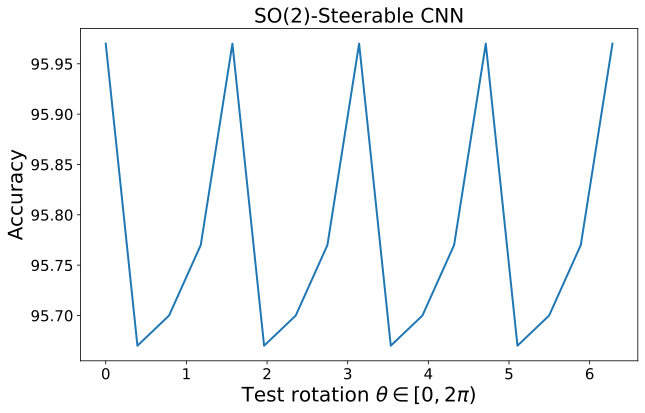

In [108]:
# plot the accuracy of as a function of the rotation of the rotation angle theta applied to the test set
fig, ax = plt.subplots(figsize = (10, 6))

N = 16

xs = [i*2*np.pi / N for i in range(N + 1)]
plt.plot(xs, accs_so2 + [accs_so2[0]])
plt.title('SO(2)-Steerable CNN', fontsize = 20)
plt.xlabel(r'Test rotation $\theta \in [0, 2\pi)$', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

In [104]:
class CNSteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes = 10):
        
        super(CNSteerableCNN, self).__init__()
        
        # the model is equivariant to rotations by multiples of 2pi/N
        self.r2_act = gspaces.rot2dOnR2(N = 4)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = nn.MaskModule(in_type, 29, margin = 1)
        
        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of C4
        activation1 = nn.ELU(nn.FieldType(self.r2_act, 8*[self.r2_act.regular_repr]), inplace = True)
        out_type = activation1.in_type
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 7, padding = 1, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation1,
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the convolution layer are 16 regular feature fields
        activation2 = nn.ELU(nn.FieldType(self.r2_act, 16*[self.r2_act.regular_repr]), inplace = True)
        out_type = activation2.in_type
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation2,
        )
        # to reduce the downsampling artifacts, we a Gaussian smoothing filter
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma = 0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the convolution layer are 32 regular feature fields
        activation3 = nn.ELU(nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr]), inplace = True)
        out_type = activation3.in_type
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation3,
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the convolution layer are 64 regular feature fields
        activation4 = nn.ELU(nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr]), inplace = True)
        out_type = activation4.in_type
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation4,
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma = 0.66, stride=2)
        ) 
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the convolution layer are 64 regular feature fields
        activation5 = nn.ELU(nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr]), inplace = True)
        out_type = activation5.in_type
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 2, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation5,
        )        
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the convolution layer are 64 regular feature fields
        activation6 = nn.ELU(nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr]), inplace = True)
        out_type = activation6.in_type
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size = 5, padding = 1, bias = False),
            nn.IIDBatchNorm2d(out_type),
            activation6,
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma = 0.66, stride=1, padding = 0)
        
        # number of output invariant channels
        c = 64
        
        # last 1x1 convolutional layer, which maps the regular fields to c = 64 invariant scalar fields
        # this is essential to provide *invariant* features in the final classification layer
        output_invariant_type = nn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = nn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)
        
        # Fully Connected classifier
        self.fully_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(c),
            torch.nn.ELU(inplace = True),
            torch.nn.Linear(c, n_classes),
        )
        
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)
        
        # mask out the corners of the input image
        x = self.mask(x)
        
        # apply each equivariant block 
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # extract the invariant features
        x = self.invariant_map(x)
        
        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [105]:
torch.manual_seed(42)
model_c4 = CNSteerableCNN().to(device)
train(model_c4, checkpoint_path='steerable_c4-pretrained.ckpt')

accuracy = test(model_c4)
print(f"Test accuracy: {accuracy}")

accs_c4 = test_model_rotations(model_c4, 16, 10000, checkpoint_path = "steerable_c4-accuracies.npy")

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0 | test accuracy: 82.044
epoch 10 | test accuracy: 91.988
epoch 20 | test accuracy: 93.62
Test accuracy: 93.62


  0%|          | 0/16 [00:00<?, ?it/s]

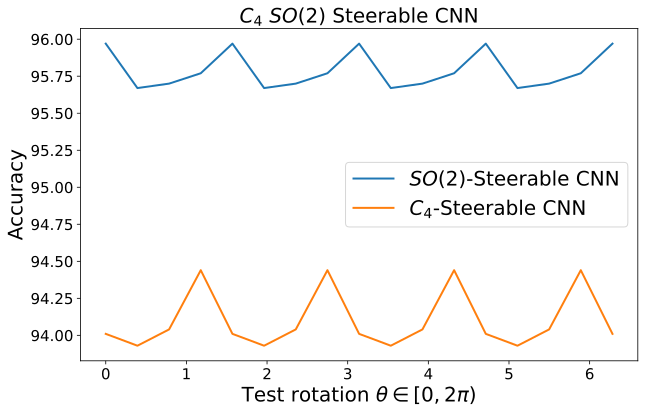

In [110]:
# plot the accuracy of as a function of the rotation of the rotation angle theta applied to the test set
fig, ax = plt.subplots(figsize = (10, 6))

N = 16

xs = [i*2*np.pi / N for i in range(N + 1)]
plt.plot(xs, accs_so2 + [accs_so2[0]], label = '$SO(2)$-Steerable CNN')
plt.plot(xs, accs_c4 + [accs_c4[0]], label = '$C_4$-Steerable CNN')
plt.title(r'$C_4$ $SO(2)$ Steerable CNN', fontsize = 20)
plt.xlabel(r'Test rotation $\theta \in [0, 2\pi)$', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(fontsize = 20)
plt.show()